In [1]:
import plotly.express as px
import numpy as np
import pandas as pd
# import plotly.graph_objects as go

In [14]:
#Load initial data
dat = pd.read_csv('Covid19_Data.csv', index_col = 0)
dat.index = pd.to_datetime(dat.index)

In [15]:
#Housekeeping to make into multiindex.
col = dat.columns.str.split('_', expand=True)
dat.columns = col
dat.index = dat.index.rename("Date")
dat.columns = dat.columns.rename(['Country', 'Col'])
dat = dat.stack(level=0)

In [17]:
jhu_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
jhu_df = pd.read_csv(jhu_url, error_bad_lines = False)

jhu_df = jhu_df.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1)
jhu_df = jhu_df.stack().rename('Confirmed').to_frame()


# jhu_df
jhu_df.index = jhu_df.index.rename(['Country', 'Date'])
jhu_df.index = jhu_df.index.set_levels([jhu_df.index.levels[0], pd.to_datetime(jhu_df.index.levels[1])])

jhu_death_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
jhu_death_df = pd.read_csv(jhu_death_url, error_bad_lines = False)

jhu_death_df = jhu_death_df.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1)
jhu_death_df = jhu_death_df.stack().rename('Dead').to_frame()

jhu_death_df.index = jhu_death_df.index.rename(['Country', 'Date'])
jhu_death_df.index = jhu_death_df.index.set_levels([jhu_death_df.index.levels[0], pd.to_datetime(jhu_death_df.index.levels[1])])

jhu_df = jhu_death_df.join(jhu_df)
jhu_death_df = None

jhu_df.index = jhu_df.index.reorder_levels(["Date", "Country"])
# jhu_df
# jhu_df.loc['Panama'], dat.loc['Panama']['Confirmed']

In [18]:
# dat.unstack().join(jhu_df.unstack(), rsuffix = '_JHU')
# dat.join(jhu_df, rsuffix = '_JHU')
# pd.concat([dat, jhu_df], axis=1 , join = 'inner' )
dat = pd.merge(dat, jhu_df, left_index=True, right_index=True, how = 'outer', suffixes = ('', '_JHU'))
dat['Confirmed'] = dat['Confirmed'].combine_first(dat['Confirmed_JHU'])
dat['Dead'] = dat['Dead'].combine_first(dat['Dead_JHU'])

dat = dat.drop(['Confirmed_JHU', 'Dead_JHU'], axis=1)
# dat.unstack()

In [19]:
def get_divide_cols_fn(c1, c2, res):
    def f(df):
        df[res] = df[c1]/df[c2]
        return df
    return f

In [20]:
#Add New Cases, New Tests
dat['NewCases'] = dat.groupby('Country')['Confirmed'].diff()
dat['NewTests'] = dat.groupby('Country')['TotalTests'].diff()
# dat['DaysSinceFirst'] = dat.groupby('Country')['Confirmed'].cumcount() + 1
dat['DaysSinceFirst'] = (dat['Confirmed'] >= 1).groupby('Country').cumsum().replace(0, np.nan)
dat['ConfirmedGrowth'] = dat.groupby('Country')['Confirmed'].pct_change() * 100.
dat['DaysSinceTenthDeath'] = (dat['Dead'] >= 10).groupby('Country').cumsum().replace(0, np.nan)

dat = dat.groupby('Country').apply(get_divide_cols_fn("NewCases", "NewTests", "DailyPosTestRate"))
dat = dat.groupby('Country').apply(get_divide_cols_fn("Confirmed", "TotalTests", "CumulativePosTestRate"))
# dat['DaysSince'] = dat.groupby('Country')['Confirmed'].expanding(1).count()
# dat['DailyPosTestRate'] = dat.groupby(level=1)['NewCases']/dat.groupby(level=1)['NewTests']


In [21]:
dat.tail(10)
dat = dat.set_index([dat.index, "DaysSinceFirst"]).reorder_levels(["Country", "DaysSinceFirst", "Date"]).sort_index()

In [22]:
dat.tail(30)

countries = list(dat.index.get_level_values(0).unique())
stats = list(dat.columns)
stat_map = {
    'DailyPosTestRate': 'Daily Positive Test Rate',
    'Confirmed': 'Confirmed Tests',
    'NewTests': 'Daily New Tests',
    'CumulativePosTestRate': 'Cumulative Positive Test Rate',
    'NewCases': 'New Cases',
    'TotalTests': 'Total Tests',
    'ConfirmedGrowth': 'Daily Confirmed Cases Growth (%)'
}

xs = ['DaysSinceFirst', 'Date', 'DaysSinceTenthDeath']
xs_map = {'DaysSinceFirst': 'Days Since First Confirmed',
         'DaysSinceTenthDeath': 'Days Since 10th Death'}

dat.loc['Panama']

Confirmed  Dead  Home  Hosp  ICU  Shutdown  \
DaysSinceFirst Date                                                     
1.0            2020-03-09        1.0   0.0   4.0   0.0  0.0       0.0   
2.0            2020-03-10        8.0   0.0   6.0   1.0  1.0       0.0   
3.0            2020-03-11       14.0   1.0   9.0   3.0  1.0       0.0   
4.0            2020-03-12       27.0   1.0  21.0   4.0  1.0       0.0   
5.0            2020-03-13       36.0   1.0  30.0   4.0  1.0       0.0   
...                              ...   ...   ...   ...  ...       ...   
NaN            2020-03-04        0.0   0.0   NaN   NaN  NaN       NaN   
               2020-03-05        0.0   0.0   NaN   NaN  NaN       NaN   
               2020-03-06        0.0   0.0   NaN   NaN  NaN       NaN   
               2020-03-07        0.0   0.0   NaN   NaN  NaN       NaN   
               2020-03-08        0.0   0.0   NaN   NaN  NaN       NaN   

                           TotalTests  NewCases  NewTests  ConfirmedGrowth  \
DaysSinceFirst Date                                                          
1.0            2020-03-09       105.0       1.0       NaN              inf   
2.0            2020-03-10       146.0       7.0      41.0       700.000000   
3.0            2020-03-11       194.0       6.0      48.0        75.000000   
4.0            2020-03-12       401.0      13.0     207.0        92.857143   
5.0            2020-03-13       649.0       9.0     248.0        33.333333   
...                               ...       ...       ...              ...   
NaN            2020-03-04         NaN       0.0       NaN              NaN   
               2020-03-05         NaN       0.0       NaN              NaN   
               2020-03-06         NaN       0.0       NaN              NaN   
               2020-03-07         NaN       0.0       NaN              NaN   
               2020-03-08         NaN       0.0       NaN              NaN   

                           DaysSinceTenthDeath  DailyPosTestRate  \
DaysSinceFirst Date                                                
1.0            2020-03-09                  NaN               NaN   
2.0            2020-03-10                  NaN          0.170732   
3.0            2020-03-11                  NaN          0.125000   
4.0            2020-03-12                  NaN          0.062802   
5.0            2020-03-13                  NaN          0.036290   
...                                        ...               ...   
NaN            2020-03-04                  NaN               NaN   
               2020-03-05                  NaN               NaN   
               2020-03-06                  NaN               NaN   
               2020-03-07                  NaN               NaN   
               2020-03-08                  NaN               NaN   

                           CumulativePosTestRate  
DaysSinceFirst Date                               
1.0            2020-03-09               0.009524  
2.0            2020-03-10               0.054795  
3.0            2020-03-11               0.072165  
4.0            2020-03-12               0.067332  
5.0            2020-03-13               0.055470  
...                                          ...  
NaN            2020-03-04                    NaN  
               2020-03-05                    NaN  
               2020-03-06                    NaN  
               2020-03-07                    NaN  
               2020-03-08                    NaN  

[64 rows x 13 columns]

# Important Dates by Country:

### Peru
- Sourhces: ministerio de salud, wikipedia page
* March 11 - Declaran emergencia sanitaria por 90 dias
* March 13 - Suspenden vuelos internacional desde Europa y Asia
* March 16 - Teletrabajo para todos menos los esenciales
* March 17 - Cierran fronteras
* March 18 - Cuarentena general entre 8PM y 5 AM.
* https://www.dge.gob.pe/portal/

### Panama
* Something

### Guatemala
- Source: Alejandro Giammattei twitter
* March 22 - Cuarentena general entre 4 PM y 4 AM por 8 dias

In [31]:
def make_graph(count_to_plot, stat_to_plot, x_axis, plot_style = 0, m=None):
    to_add = ['Date'] if x_axis != 'Date' else []
    to_plot = dat.reset_index()
    to_plot = to_plot[to_plot.Country.isin(count_to_plot)][['Country'] + [stat_to_plot] + [x_axis] + ['Shutdown']+to_add ]
    if x_axis != 'Date':
        to_plot['Date'] = to_plot['Date'].dt.strftime('%b %d, %Y')
    print(to_plot.head())
    to_plot.Shutdown = to_plot.Shutdown.fillna(value = 0)
    
    if plot_style == 0:
        fig = px.scatter(to_plot, 
                         x = to_plot[x_axis], 
                         y = to_plot[stat_to_plot], 
                         color = to_plot.Country,
                         hover_data = ['Date'] if x_axis != 'Date' else [],
#                          symbol = 'Shutdown',
                         title = '{} by Country'.format(stat_map.get(stat_to_plot, stat_to_plot)))
    elif plot_style == 1:
        fig = px.bar(to_plot, 
                         x = to_plot[x_axis], 
                         y = to_plot[stat_to_plot], 
                         color = to_plot.Country,
                         barmode = 'group',
                         hover_data = ['Date'] if x_axis != 'Date' else [],
                         title = '{} by Country'.format(stat_map.get(stat_to_plot, stat_to_plot)))
    elif plot_style == 2:
        fig = px.line(to_plot, 
                         x = to_plot[x_axis], 
                         y = to_plot[stat_to_plot], 
                         color = to_plot.Country,
                         hover_data = ['Date'] if x_axis != 'Date' else [],
                         title = '{} by Country'.format(stat_map.get(stat_to_plot, stat_to_plot)))
#     fig.add_trace(tr)
    
#     fig.update_xaxes(title = 'Days Since First Confirmed Test')
    fig.update_xaxes(title = xs_map.get(x_axis, x_axis))
    fig.update_yaxes(title = stat_to_plot)

    if m is not None:
        x_lim = to_plot.reset_index().groupby('Country')[x_axis].max().min() * m
        y_lim = to_plot.reset_index().groupby('Country')[stat_to_plot].max().min() * m
        fig.update_xaxes(range = [0, x_lim])
        fig.update_yaxes(range = [0, y_lim])
        
    return fig



     Country  TotalTests  DaysSinceFirst  Shutdown          Date
7872  Panama       105.0             1.0       0.0  Mar 09, 2020
7873  Panama       146.0             2.0       0.0  Mar 10, 2020
7874  Panama       194.0             3.0       0.0  Mar 11, 2020
7875  Panama       401.0             4.0       0.0  Mar 12, 2020
7876  Panama       649.0             5.0       0.0  Mar 13, 2020


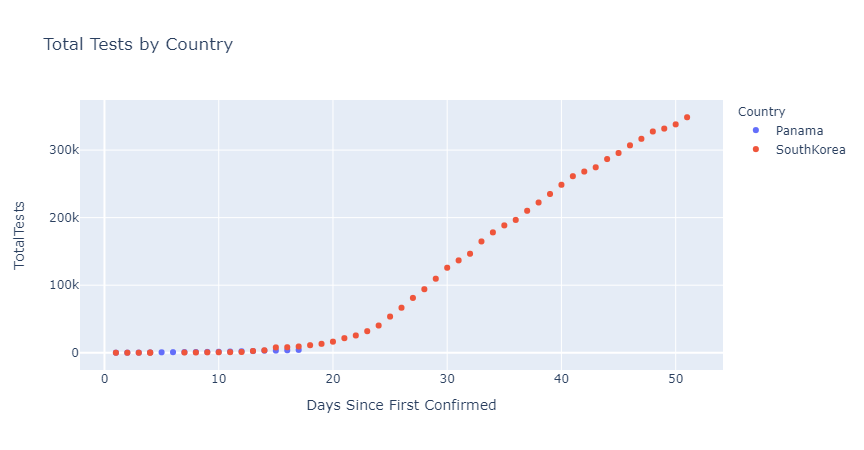

In [32]:
count_to_plot = ['Panama', 'SouthKorea']
y_to_plot =  'TotalTests'
x_lab = 'DaysSinceFirst'
x_axis = x_lab
stat_to_plot = y_to_plot
f = make_graph(count_to_plot, y_to_plot, x_lab, plot_style=0)
f

In [26]:
to_add = ['Date'] if x_axis != 'Date' else []
to_plot = dat.reset_index()
to_plot = to_plot[to_plot.Country.isin(count_to_plot)][['Country'] + [stat_to_plot] + [x_axis] + ['Shutdown']+to_add ]
if x_axis != 'Date':
    to_plot['Date'] = to_plot['Date'].dt.strftime('%b %d, %Y')
# print(to_plot)
to_plot.Shutdown = to_plot.Shutdown.fillna(value = 0)
to_plot

,Country,TotalTests,DaysSinceFirst,Shutdown,Date
7872,Panama,105.0,1.0,0.0,"Mar 09, 2020"
7873,Panama,146.0,2.0,0.0,"Mar 10, 2020"
7874,Panama,194.0,3.0,0.0,"Mar 11, 2020"
7875,Panama,401.0,4.0,0.0,"Mar 12, 2020"
7876,Panama,649.0,5.0,0.0,"Mar 13, 2020"
...,...,...,...,...,...
9455,SouthKorea,316664.0,47.0,0.0,"Mar 19, 2020"
9456,SouthKorea,327509.0,48.0,0.0,"Mar 20, 2020"
9457,SouthKorea,331780.0,49.0,0.0,"Mar 21, 2020"
9458,SouthKorea,338036.0,50.0,0.0,"Mar 22, 2020"


In [44]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from jupyter_plotly_dash import JupyterDash
# import jupyterlab_dash

In [51]:
# viewer = jupyterlab_dash.AppViewer()
# app = dash.Dash('Covid-Tracking')
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash('Covid-Tracking')

In [52]:
app.layout = html.Div([
    html.Div([
        html.H2('COVID-19 Tracking',)
    ]),
    html.Div([    
        html.P(["Countries:", 
            dcc.Dropdown(
                id = 'country-select',
    #             options = countries,
                options = [{'label': stat_map.get(c, c), 'value': c} for c in countries],
                value = ['Panama'],
                multi = True
            )
        ]),
    ], style = {"width": "30%", 'display': 'inline-block', 'text-align': 'center'} ),
    html.Div([
        html.P(["Statistics:",
            dcc.Dropdown(
                id = 'statistic-select',
                options = [{'label': stat_map.get(s, s), 'value': s} for s in stats],
                value = ['Confirmed'],
                multi=True
            )
        ])
    ], style = {'width':'30%', 'display':'inline-block', 'text-align': 'center'}),
    html.Div([
        html.P(["X-Axis:",
            dcc.Dropdown(
                id = 'x-axis-select',
                options = [{'label': xs_map.get(x, x), 'value': x} for x in xs],
                value = 'DaysSinceFirst',
                multi=False
            )
        ])
    ], style = {'width':'20%', 'display':'inline-block', 'text-align': 'center'}),
    html.Div([
        html.P(["Graph Style:",
            dcc.Dropdown(
                id = 'graph-style',
                options = [{'label': 'Scatter', 'value': 0}, 
                           {'label': 'Bar' , 'value': 1},
                           {'label': 'Line', 'value': 2}],
                value = 0,
                multi=False
            )
        ])
    ], style = {'width':'20%', 'display':'inline-block', 'text-align': 'center'}),
    
    html.Div(children = html.Div(id='graphs'), className = 'row', style = {"display":'inline-block', 'width': '100%'}),
    
#     dcc.Graph(id='graphs', style = {'width': '80%', 'display': 'inline-block'}),
], className = 'container'
)


@app.callback(
    dash.dependencies.Output('graphs', 'children'),
    [dash.dependencies.Input('country-select', 'value'), dash.dependencies.Input('statistic-select', 'value'),
    dash.dependencies.Input('x-axis-select', 'value'), dash.dependencies.Input('graph-style', 'value')]
)
def update_graph(countries, stats, x_axis, graph_style):
    if len(stats)>2:
        class_choice = 'col s12 m6 l4'
    elif len(stats) == 2:
        class_choice = 'col s12 m6 l6'
    else:
        class_choice = 'col s12'
    #Returns a list of graphs
    graphs = []
#     return make_graph(countries, stats[0], scatter=False)
    for plot_stat in stats:
        g = make_graph(countries, plot_stat, x_axis, plot_style=graph_style)
        graphs.append(html.Div(dcc.Graph(
            id = plot_stat,
            animate = True,
            figure = g        
            ), className = class_choice
        ))
    return graphs
# viewer.show(app)

In [53]:
app

In [33]:
countries

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Holy See',
 'Honduras',
 'Hungary'